In [1]:
import torch
factor = 16
linear_dim = 77824*2
linear_dim2 = int( linear_dim/ factor) 
linear_dim3 = int(linear_dim/ (factor*factor))
linear_dim4 = int(linear_dim/ (factor*factor*factor))

class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = torch.nn.Sequential(
                torch.nn.Conv2d(1, 512, (3,3), stride=2,padding=1 ),
                torch.nn.LayerNorm(512),
                torch.nn.GELU(),
                torch.nn.Conv2d(512, 256, (3,3), stride=2,padding=1 ),
                torch.nn.LayerNorm(256),
                torch.nn.GELU(),
                torch.nn.Conv2d(256, 64, (3,3), stride=2,padding=1 ),
                torch.nn.LayerNorm(128),
                torch.nn.GELU(),   
                torch.nn.Flatten()  
            )
     

        self.dense_encoder = torch.nn.Sequential(
            torch.nn.Linear(linear_dim, linear_dim2 ),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(linear_dim2, linear_dim3 ),
            torch.nn.LeakyReLU(),
           
        )
        
        
        # self.encoder = torch.nn.Sequential(
        #     torch.nn.Conv2d(1, 64, 3, stride=1, padding=1),  # 
        #     torch.nn.ReLU(True),
        #     torch.nn.MaxPool2d(2, stride=1),
        #     torch.nn.Conv2d(64, 16, 3, stride=1, padding=1),  # b, 8, 3, 3
        #     torch.nn.ReLU(True),
        #     torch.nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        # )

        # self.decoder = torch.nn.Sequential(
        #     torch.nn.Upsample(scale_factor=1, mode='nearest'),
        #     torch.nn.Conv2d(16, 64, 3, stride=1, padding=1),  # b, 16, 10, 10
        #     torch.nn.ReLU(True),
        #     torch.nn.Upsample(scale_factor=1, mode='nearest'),
        #     torch.nn.Conv2d(64, 1, 3, stride=1, padding=2),  # b, 8, 3, 3
        #     torch.nn.Sigmoid()
        # )

    def forward(self, x):
        coded = self.encoder(x)
        latent = self.dense_encoder(coded)
        return latent


In [2]:
class Decoder(torch.nn.Module): 
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.dense_decoder = torch.nn.Sequential(

            torch.nn.Linear(linear_dim3, linear_dim2),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(linear_dim2, linear_dim ),
            torch.nn.LeakyReLU(),
        )

        self.decoder = torch.nn.Sequential(
                torch.nn.Unflatten(1, (64,19,128)),
            torch.nn.ConvTranspose2d(64, 256, (3,3), stride=2, padding=1, output_padding=1),
                torch.nn.LayerNorm(256),
                torch.nn.GELU(),
                torch.nn.ConvTranspose2d(256, 512, (3,3), stride=2, padding=1, output_padding=1),
                torch.nn.LayerNorm(512),
                torch.nn.GELU(),
                torch.nn.ConvTranspose2d(512, 768, (3,3), stride=2, padding=1, output_padding=1),
                torch.nn.LayerNorm(1024),
                torch.nn.GELU(), 
                torch.nn.ConvTranspose2d(768, 1, (1,1), stride=1, ),
                torch.nn.LayerNorm(1024),
                torch.nn.GELU(),    
            )
    def forward(self,x):
        decoded_laten = self.dense_decoder(x)
        decoded = self.decoder(decoded_laten)
        return decoded

In [3]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = Encoder().to("cuda:0")
        self.decoder = Decoder().to("cuda:1")

    
    def forward(self, x):
        x.to("cuda:0")
        encoded = self.encoder(x)
        bro = encoded.to("cuda:1")
        
        decoded = self.decoder(bro)
        return decoded

In [4]:
# from torchsummary import summary

# model = Encoder().to("cuda:0")
# summary(model, (1,152,1024))

In [5]:
# model = Decoder().to("cuda:0")
# summary(model, (linear_dim3))

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
def plotImg(a: torch.Tensor):
    plt.imshow(a.numpy(force=True), norm=colors.LogNorm())
    plt.colorbar()
    plt.show()

def plotDiff(a: torch.Tensor, b: torch.Tensor):
    plotImg(torch.subtract(a,b))

In [7]:
from PIL import Image
from torchvision import transforms
import os
from matplotlib.pyplot import plot 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

image1 = Image.open("black_dock.png").convert("RGB")
image2 = Image.open("flower.jpg").convert("RGB")
transform = transforms.Compose( [transforms.Resize((700, 1024)), transforms.ToTensor(), transforms.Grayscale(), 
                                 transforms.Normalize(mean=2.9886, std=154.1467)])

# data = torch.tensor(torch.stack([transform(image1), transform(image2)])).to("cuda:0")

with open(os.path.join("data", "0.pt"), "rb") as f:
    s_s = torch.load(f)
with open(os.path.join("data", "1.pt"), "rb") as f:
    s_s1 = torch.load(f)


# s_s = s_s.unsqueeze(0)
s_s = s_s.to("cuda:0")
s_s1 = s_s1.to("cuda:0")
normalize = transforms.Normalize(mean=2.9886, std=154.1467)
data = torch.stack([s_s, s_s1])


23795.701171875
23784.869140625
23766.7421875
23723.3984375
23635.986328125
23564.798828125
23545.52734375
23534.861328125
23524.056640625
23517.76953125
23515.7109375
23515.58203125
23515.70703125
23515.568359375
23515.203125
23514.69140625
23514.095703125
23513.45703125
23512.826171875
23512.248046875
23511.767578125
23511.388671875
23511.109375
23510.9140625
23510.77734375
23510.671875
23510.580078125
23510.478515625
23510.365234375
23510.240234375
23510.111328125
23509.982421875
23509.861328125
23509.75390625
23509.669921875
23509.6015625
23509.552734375
23509.509765625
23509.474609375
23509.43359375
23509.38671875
23509.3359375
23509.2734375
23509.21484375
23509.154296875
23509.1015625
23509.052734375
23509.01171875
23508.974609375
23508.943359375
23508.908203125
23508.875
23508.83984375
23508.796875
23508.755859375
23508.71484375
23508.671875
23508.630859375
23508.591796875
23508.556640625
23508.521484375
23508.486328125
23508.451171875
23508.416015625
23508.380859375
23508.34375

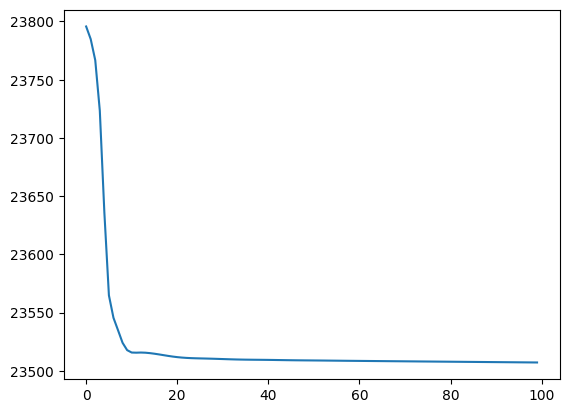

In [8]:
conv = AutoEncoder()
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(conv.parameters(), lr=0.001)
inputBatch = [torch.stack([torch.stack([data[0]])]), torch.stack([torch.stack([data[1]])])]
losses = []
for i in range(100):
    optimizer.zero_grad()
    decoded = conv(inputBatch[0] )
    loss = loss_fn(decoded, inputBatch[0].to("cuda:1"))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(loss.item())

plot(range(len(losses)),losses)

In [9]:
plotDiff(conv(inputBatch[0])[0], inputBatch[0][0])

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!

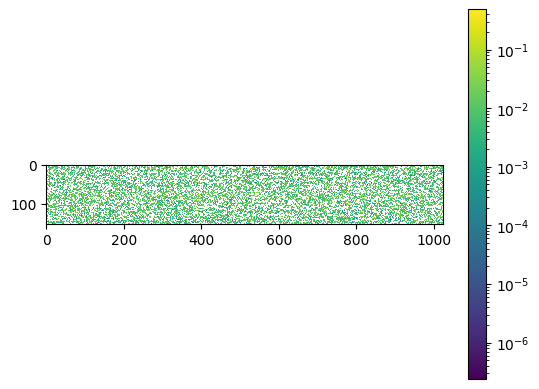

In [ ]:
plotDiff(torch.sigmoid(inputBatch[1][0]), torch.sigmoid(inputBatch[0][0]))
